In [1]:
import os

import IPython.display as ipd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image

from lib.utils import float2d_to_rgb
from src.config import c
from src.generator import Generator
from src.msg_provider import MSG_Provider
from src.services import get_msg_provider, get_wave_provider
from src.wave_provider import WaveProvider

In [2]:
def _get_msg_p(n_mels=380, time_steps=380, power=3, n_fft=2048):
    return MSG_Provider(
        n_mels=n_mels,
        target_n_mels=n_mels,
        time_steps=time_steps,
        n_fft=n_fft,
        power=power,
        target_time_steps=time_steps,
        sample_rate=c["AUDIO_SR"],
        normalize=c["MSG_NORMALIZE"],
        f_min=c["MSG_FREQ_RANGE"][0],
        f_max=c["MSG_FREQ_RANGE"][1],
        audio_len_seconds=c["AUDIO_TARGET_LEN_S"],
        device="cpu",
    )


def _get_wave_p(normalize=True):
    return WaveProvider(
        audio_sr=c["AUDIO_SR"],
        cache_dir=None,
        src_dirs=c["SRC_DATA_DIRS"],
        normalize=normalize,
    )


def _show_msg(msg):
    plt.figure()
    msg = np.flip(msg, axis=0)
    plt.imshow(msg.astype(np.float32), cmap="gray")

/usr/local/lib/python3.8/dist-packages/torchaudio/functional/functional.py:357: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (380) may be set too high. Or, the value for `n_freqs` (1025) may be set too low.
  warnings.warn(


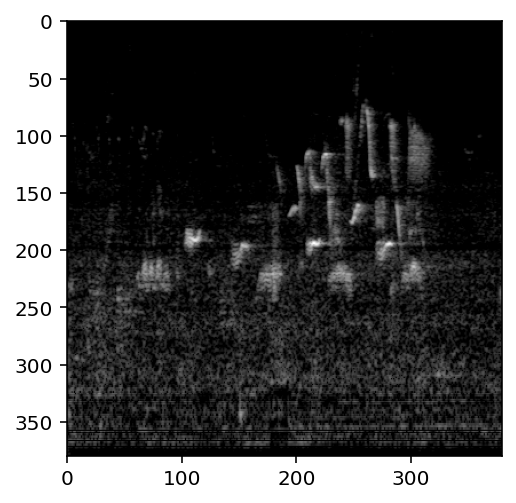

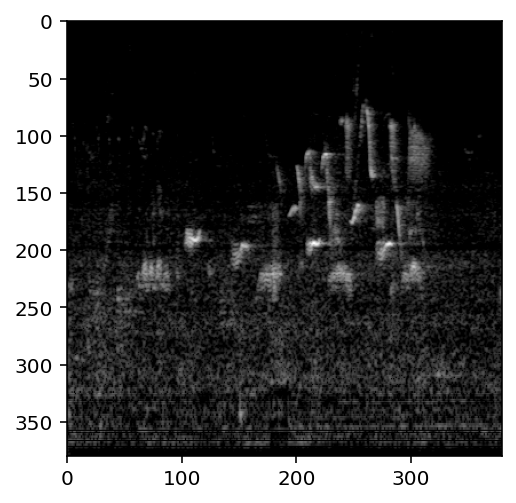

In [3]:
x1 = _get_wave_p(normalize=False).get_audio_fragment("XC602886.ogg", [0, 5])
x2 = _get_wave_p(normalize=True).get_audio_fragment("XC602886.ogg", [0, 5])
mp = _get_msg_p()

m1 = mp.msg(x1)
m2 = mp.msg(x2)

_show_msg(m1)
_show_msg(m2)

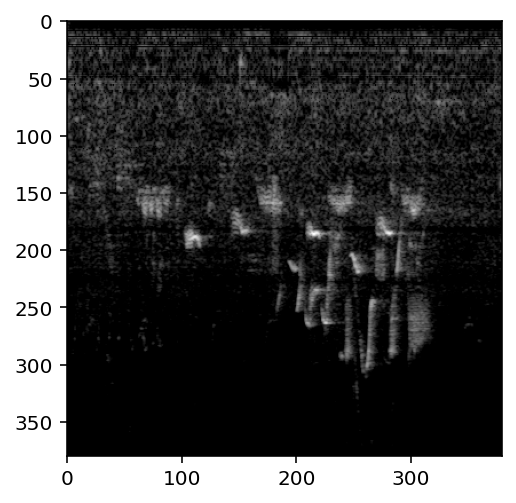

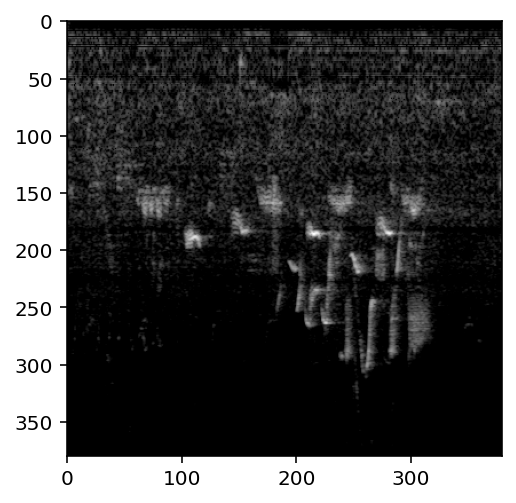

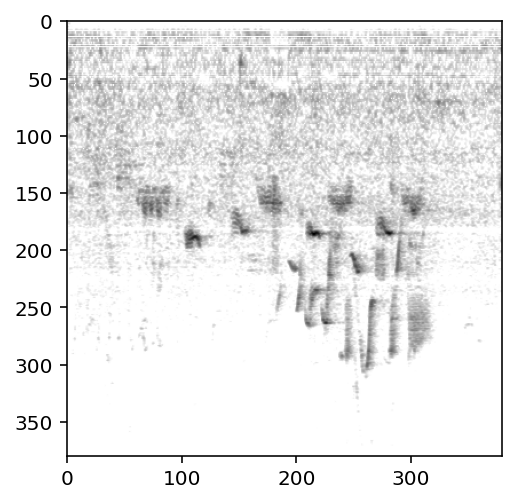

In [4]:
def _msg_to_rgb(msg):
    msg = msg.astype(np.float32)
    msg -= np.min(msg)
    msg /= np.max(msg)
    msg = msg * 255
    msg = msg.astype(np.uint8)
    msg = np.expand_dims(msg, 2)
    msg = np.repeat(msg, 3, 2)
    return msg


m1_norm = (m1 - np.mean(m1)) / np.std(m1)
plt.imshow(_msg_to_rgb(m1_norm))
plt.figure()
plt.imshow(_msg_to_rgb(m1))
plt.figure()
plt.imshow(_msg_to_rgb(m1_norm - m1))

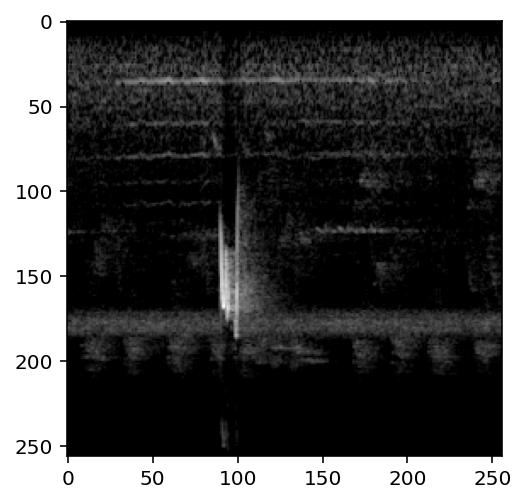

In [5]:
g = Generator(
    df=pd.read_pickle("/app/_work/dataset.pickle"),
    wave_provider=get_wave_provider(c),
    msg_provider=get_msg_provider(c, n_mels=256, time_steps=256),
    batch_size=10,
    shuffle=False,
    augmentation=None,
    msg_as_rgb=True,
)

bx, _, _ = g.__getitem__(10)

plt.imshow(bx["i_msg"][0])

In [47]:
r = 4
df = pd.read_pickle("/app/_work/dataset.pickle")
gdf = df[
    (df["_primary_labels"] == df["_primary_labels"].value_counts().index[0])
    & (df["rating"] == r)
]

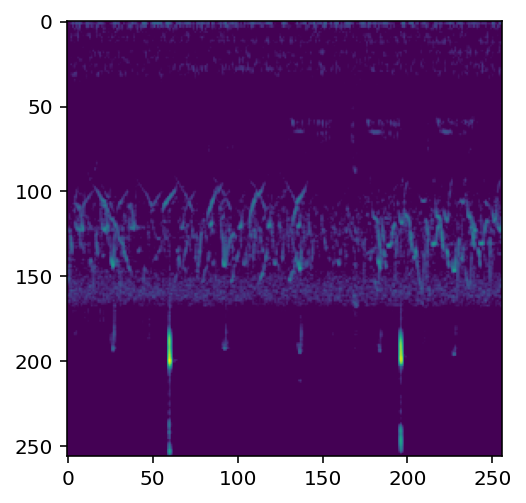

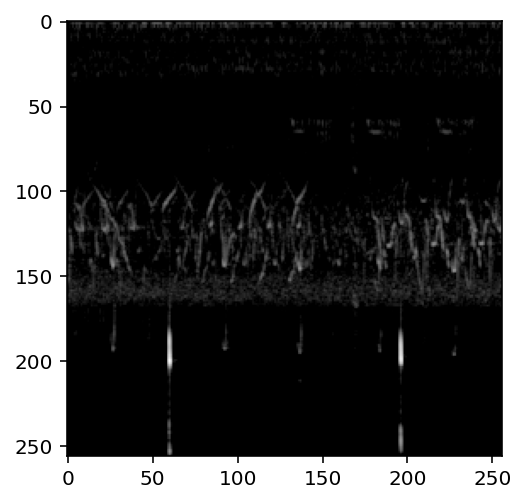

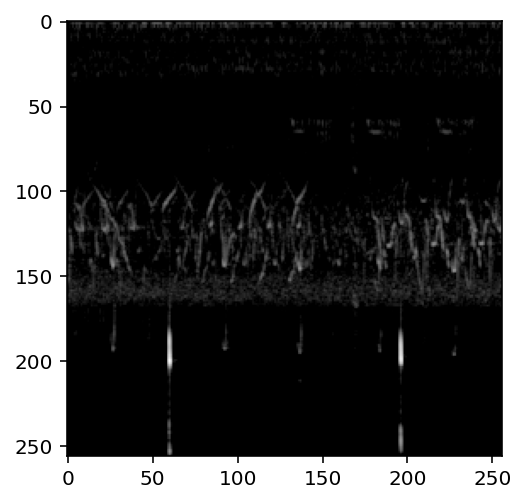

In [48]:
g = Generator(
    df=gdf,
    wave_provider=get_wave_provider(c),
    msg_provider=get_msg_provider(c, n_mels=256, time_steps=256),
    batch_size=1,
    shuffle=False,
    augmentation=None,
    msg_as_rgb=False,
)

bx, y, sw = g.__getitem__(0)

plt.imshow(bx["i_msg"][0].astype(np.float32))
plt.figure()
plt.imshow(_msg_to_rgb(bx["i_msg"][0]))
plt.figure()
plt.imshow(float2d_to_rgb(bx["i_msg"][0]))

In [49]:
assert sw == r / 5